In [14]:
import tensorflow 

import pandas as pd
import numpy as np
import os
import keras
import random
import cv2
import math
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

from tensorflow.keras.layers import Dense,GlobalAveragePooling2D,Convolution2D,BatchNormalization
from tensorflow.keras.layers import Flatten,MaxPooling2D,Dropout

from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.applications.densenet import preprocess_input

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array

from tensorflow.keras.models import Model

from tensorflow.keras.optimizers import Adam

from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

import warnings
warnings.filterwarnings("ignore")

In [15]:
print("Tensorflow-version:", tensorflow.__version__)

Tensorflow-version: 2.5.0-rc3


In [17]:
model_d=DenseNet121(weights='imagenet',include_top=False, input_shape=(128, 128, 3)) 

x=model_d.output

x= GlobalAveragePooling2D()(x)
x= BatchNormalization()(x)
x= Dropout(0.5)(x)
x= Dense(1024,activation='relu')(x) 
x= Dense(512,activation='relu')(x) 
x= BatchNormalization()(x)
x= Dropout(0.5)(x)

preds=Dense(3,activation='softmax')(x) #FC-layer

In [18]:
model=Model(inputs=model_d.input,outputs=preds)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [19]:
for layer in model.layers[:-8]:
    layer.trainable=False
    
for layer in model.layers[-8:]:
    layer.trainable=True

In [20]:
model.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 134, 134, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 64, 64, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 64, 64, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [21]:
data=[]
labels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("./Deep_data/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("./Deep_data/"+img)))
    for i in path:
        image = cv2.imread("./Deep_data/"+img+'/'+i)
        image = cv2.resize(image, (128,128))
        image = img_to_array(image)
        data.append(image)
        l = label = img
        labels.append(l)

['normal', 'glaucoma', 'other']


In [22]:
data = np.array(data, dtype="float32") / 255.0
labels = np.array(labels)
mlb = LabelBinarizer()
labels = mlb.fit_transform(labels)
print(labels[0])

[0 1 0]


In [23]:
(xtrain,xtest,ytrain,ytest)=train_test_split(data,labels,test_size=0.2,random_state=42)
print(xtrain.shape, xtest.shape)

(227, 128, 128, 3) (57, 128, 128, 3)


In [24]:
anne = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, verbose=1, min_lr=1e-3)
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(xtrain)
# Fits-the-model
history = model.fit_generator(datagen.flow(xtrain, ytrain, batch_size=64),
               epochs=10,
               verbose=1,
               callbacks=[anne, checkpoint],
               validation_data=(xtest, ytest))

Epoch 1/10
8/8 [==============================] - 25s 2s/step - loss: 1.2476 - accuracy: 0.5771 - val_loss: 0.6216 - val_accuracy: 0.7719

Epoch 00001: val_loss improved from inf to 0.62160, saving model to model.h5
Epoch 2/10
8/8 [==============================] - 12s 2s/step - loss: 0.7634 - accuracy: 0.7885 - val_loss: 0.7359 - val_accuracy: 0.6491

Epoch 00002: val_loss did not improve from 0.62160
Epoch 3/10
8/8 [==============================] - 12s 2s/step - loss: 0.5828 - accuracy: 0.8458 - val_loss: 0.8557 - val_accuracy: 0.5965

Epoch 00003: val_loss did not improve from 0.62160
Epoch 4/10
8/8 [==============================] - 12s 1s/step - loss: 0.3763 - accuracy: 0.8590 - val_loss: 0.5943 - val_accuracy: 0.7193

Epoch 00004: val_loss improved from 0.62160 to 0.59428, saving model to model.h5
Epoch 5/10
8/8 [==============================] - 12s 1s/step - loss: 0.4967 - accuracy: 0.8811 - val_loss: 0.3830 - val_accuracy: 0.8596

Epoch 00005: val_loss improved from 0.59428 t

In [32]:
testdata=[]
testlabels=[]
random.seed(42)
imagePaths = sorted(list(os.listdir("./Test/")))
random.shuffle(imagePaths)
print(imagePaths)

for img in imagePaths:
    path=sorted(list(os.listdir("./Test/"+img)))
    for i in path:
        image = cv2.imread("./Test/"+img+'/'+i)
        image = cv2.resize(image, (128,128))
        image = img_to_array(image)
        testdata.append(image)
        l = label = img
        testlabels.append(l)

['normal', 'glaucoma', 'other']


In [33]:
testdata = np.array(testdata, dtype="float32") / 255.0
testlabels = np.array(testlabels)
mlb = LabelBinarizer()
testlabels = mlb.fit_transform(testlabels)
print(labels[0])

[0 1 0]


In [34]:
datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip=True, shear_range=0.2)


datagen.fit(testdata)

In [37]:

ypred = model.predict(testdata)

total = 0
accurate = 0
accurateindex = []
wrongindex = []

for i in range(len(ypred)):
    if np.argmax(ypred[i]) == np.argmax(testlabels[i]):
        accurate += 1
        accurateindex.append(i)
    else:
        wrongindex.append(i)
        
    total += 1
    
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate/total*100, 3), '%')

Total-test-data; 70 	accurately-predicted-data: 41 	 wrongly-predicted-data:  29
Accuracy: 58.571 %


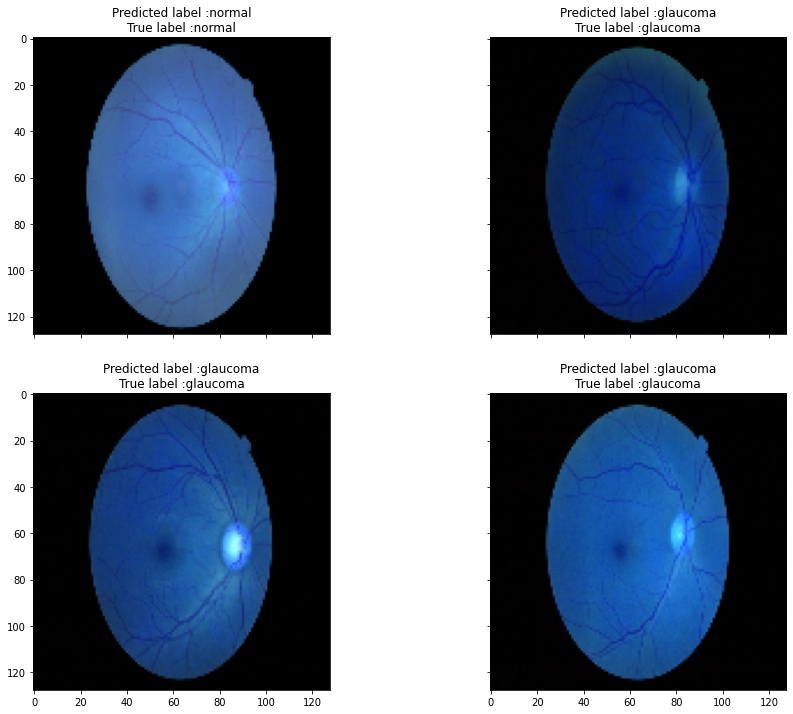

In [38]:
label=['glaucoma', 'normal', 'other']
imidx = random.sample(accurateindex, k=4)# replace with 'wrongindex'

nrows = 2
ncols = 2
fig, ax = plt.subplots(nrows,ncols,sharex=True,sharey=True,figsize=(15, 12))

n = 0
for row in range(nrows):
    for col in range(ncols):
            ax[row,col].imshow(testdata[imidx[n]])
            ax[row,col].set_title("Predicted label :{}\nTrue label :{}".format(label[np.argmax(ypred[imidx[n]])], label[np.argmax(testlabels[imidx[n]])]))
            n += 1

plt.show()

Text(0.5, 145.31999999999996, 'Predicted')

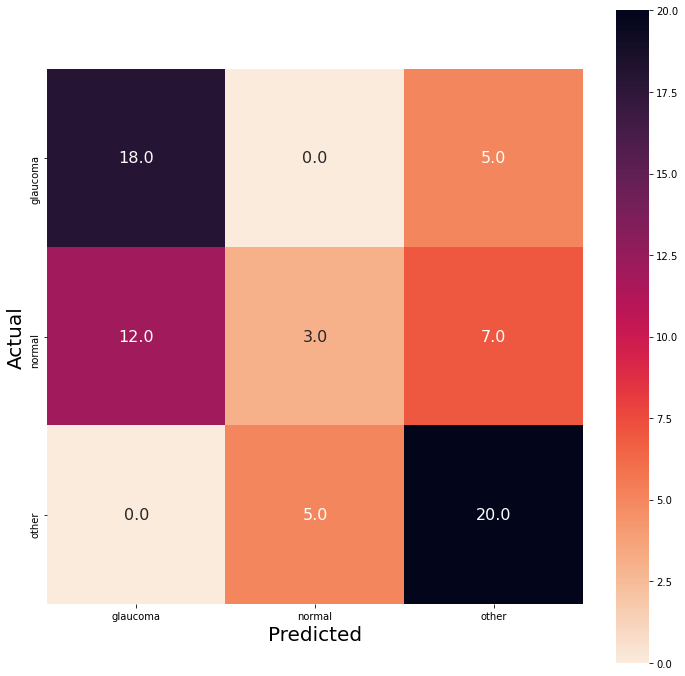

In [39]:
Ypred = model.predict(testdata)

Ypred = np.argmax(Ypred, axis=1)
Ytrue = np.argmax(testlabels, axis=1)

cm = confusion_matrix(Ytrue, Ypred)
plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap="rocket_r", fmt=".01f",annot_kws={'size':16}, annot=True, square=True, xticklabels=label, yticklabels=label)
ax.set_ylabel('Actual', fontsize=20)
ax.set_xlabel('Predicted', fontsize=20)

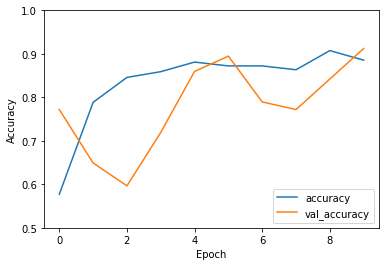

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1]) 
plt.legend(loc='lower right')


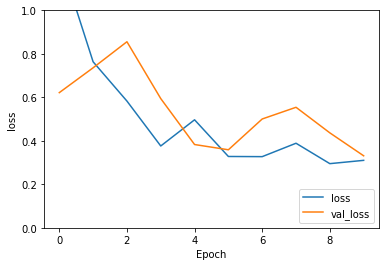

In [41]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend(loc='lower right')
